In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fasttextembeddings/cc.en.300.bin
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [2]:
import pandas as pd
import re
import numpy as np
import fasttext
import fasttext.util
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:
import os

# Specify the file path
file_path = '/kaggle/working/cc.en.300.bin'

# Check if the file exists before deleting
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File {file_path} deleted successfully.")
else:
    print(f"File {file_path} does not exist.")


File /kaggle/working/cc.en.300.bin does not exist.


In [6]:
train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')
test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv')

In [7]:
merged_test_data = pd.merge(test_data, test_labels, on='id')
filtered_test_data = merged_test_data[(merged_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] != -1).all(axis=1)]

In [8]:
# Create 'is_toxic' label
filtered_test_data['is_toxic'] = filtered_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
train_data['is_toxic'] = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
class_distribution = train_data['is_toxic'].value_counts()
print(class_distribution)
class_proportions = class_distribution / len(train_data)
print(class_proportions)

is_toxic
0    143346
1     16225
Name: count, dtype: int64
is_toxic
0    0.898321
1    0.101679
Name: count, dtype: float64


/tmp/ipykernel_34/2263514747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['is_toxic'] = filtered_test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)


In [9]:
num_rows = filtered_test_data.shape[0]
print(f"Number of rows in filtered_test_data: {num_rows}")

Number of rows in filtered_test_data: 63978


In [11]:
# Clean the comment text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = text.strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [13]:
train_data['cleaned_comment'] = train_data['comment_text'].apply(clean_text)
filtered_test_data['cleaned_comment'] = filtered_test_data['comment_text'].apply(clean_text)

/tmp/ipykernel_34/1713112218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_data['cleaned_comment'] = filtered_test_data['comment_text'].apply(clean_text)


In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['cleaned_comment'])

In [15]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_data['cleaned_comment'])
X_test_seq = tokenizer.texts_to_sequences(filtered_test_data['cleaned_comment'])

In [16]:
# Pad sequences
max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [18]:
# Load FastText embeddings
#fasttext.util.download_model('en', if_exists='ignore')  # English
#ft = fasttext.load_model('cc.en.300.bin')

model_path = '/kaggle/input/fasttextembeddings/cc.en.300.bin'
ft = fasttext.load_model(model_path)

In [19]:
# Create embedding matrix
embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
# Define LSTM model
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])


In [ ]:
# Balance classes in the training data
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=42)
#X_train_res, y_train_res = ros.fit_resample(X_train_pad, train_data['is_toxic'])


In [24]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_train_res, y_train_res = smote.fit_resample(X_train_pad, train_data['is_toxic'])

# Now you can use X_train_res and y_train_res for training your model


In [25]:
# Train the model
history = model.fit(X_train_res, y_train_res, epochs=10, batch_size=128, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test_pad)
y_pred_class = (y_pred > 0.5).astype(int)

Epoch 1/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - accuracy: 0.7485 - loss: 0.4861 - val_accuracy: 0.7748 - val_loss: 0.4638
Epoch 2/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8734 - loss: 0.2889 - val_accuracy: 0.8893 - val_loss: 0.2502
Epoch 3/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.8975 - loss: 0.2395 - val_accuracy: 0.8759 - val_loss: 0.2767
Epoch 4/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9122 - loss: 0.2087 - val_accuracy: 0.8906 - val_loss: 0.2490
Epoch 5/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9213 - loss: 0.1880 - val_accuracy: 0.8968 - val_loss: 0.2352
Epoch 6/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9277 - loss: 0.1753 - val_accuracy: 0.9237 - val_loss: 0.1825
Epoch 7/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9329 - loss: 0.1629 - val_accuracy: 0.8926 - val_loss: 0.2441
Epoch 8/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9379 -

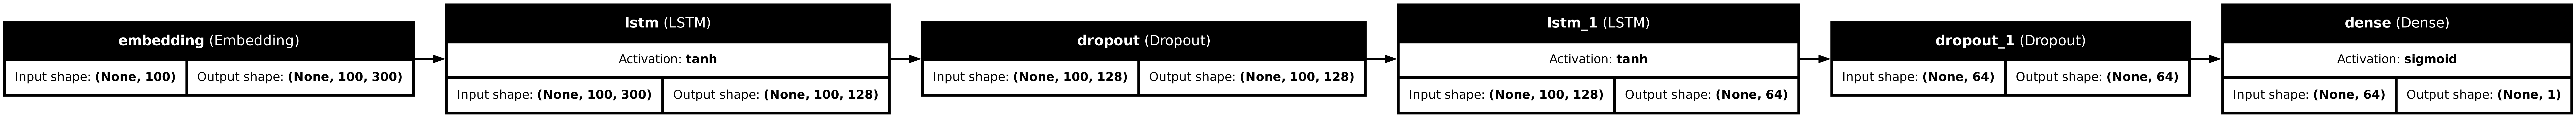

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file='/kaggle/working/model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR',                # Layout from left to right
    expand_nested=True,          # Expand nested structures
    show_layer_activations=True, # Show layer activations
    dpi=300                      # Higher resolution
)



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     57735
           1       0.44      0.89      0.59      6243

    accuracy                           0.88     63978
   macro avg       0.71      0.88      0.76     63978
weighted avg       0.93      0.88      0.89     63978

AUC: 0.9512916498174498


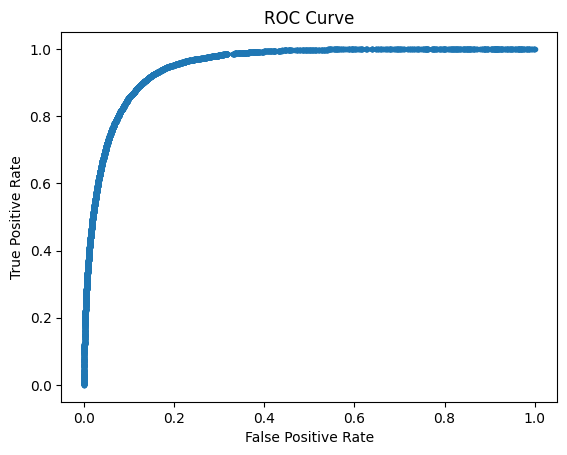

KS Statistic: 0.7708556472311082


In [30]:
print("Classification Report:")
print(classification_report(filtered_test_data['is_toxic'], y_pred_class))

# Calculate AUC
auc_score = roc_auc_score(filtered_test_data['is_toxic'], y_pred)
print(f"AUC: {auc_score}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(filtered_test_data['is_toxic'], y_pred)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# KS statistic
ks_statistic = max(tpr - fpr)
print(f"KS Statistic: {ks_statistic}")